# Group Analysis

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from src import plotting
from src.stats import calculate_p, cluster_correction
from scipy import ndimage
from tqdm import tqdm

In [2]:
process = 'Group_Analysis'
top_path = '/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_analysis'
input_path = f'{top_path}/data/interim'
out_path = f'{top_path}/data/interim/{process}'
figure_path = f'{top_path}/reports/figures/{process}'
Path(out_path).mkdir(parents=True, exist_ok=True)
Path(figure_path).mkdir(parents=True, exist_ok=True)

regress_gaze = False
overwrite = False

In [3]:
rois = ['EVC', 'MT', 'EBA',
        'LOC', 'FFA', 'PPA',
        'pSTS', 'face-pSTS', 'aSTS']
features = ['alexnet', 'moten', 'indoor',
                 'expanse', 'object_directedness', 'agent_distance',
                 'facingness', 'joint_action', 'communication', 
                 'valence', 'arousal']
annotated_features = ['indoor', 'expanse', 'object_directedness', 
                 'agent_distance', 'facingness', 'joint_action', 
                 'communication', 'valence', 'arousal']

In [4]:
def load_files(files, cat=None, cat_order=None, subj_exclude=[]):
    group = []
    subjs = []
    for file in files:
        subj = file.split('/')[-1].split('_')[0]
        if subj not in subj_exclude: 
            subjs.append(subj)
            if 'pkl' in file:
                df = pd.read_pickle(file)
            else:
                df = pd.read_csv(file)
            df['subj'] = subj
            if 'Unnamed: 0' in df.columns:
                df.drop(columns=['Unnamed: 0'], inplace=True)
            group.append(df)
    group = pd.concat(group)
    if cat and cat_order:
        cat_type = pd.CategoricalDtype(categories=cat_order, ordered=True)
        group[cat] = group[cat].astype(cat_type)
    return group, subjs

def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

## Pairwise decoding

['sub-03', 'sub-02', 'sub-01', 'sub-05', 'sub-04', 'sub-08', 'sub-06', 'sub-09', 'sub-11', 'sub-10', 'sub-12', 'sub-13', 'sub-17', 'sub-19', 'sub-16', 'sub-18', 'sub-21', 'sub-14', 'sub-15', 'sub-20']


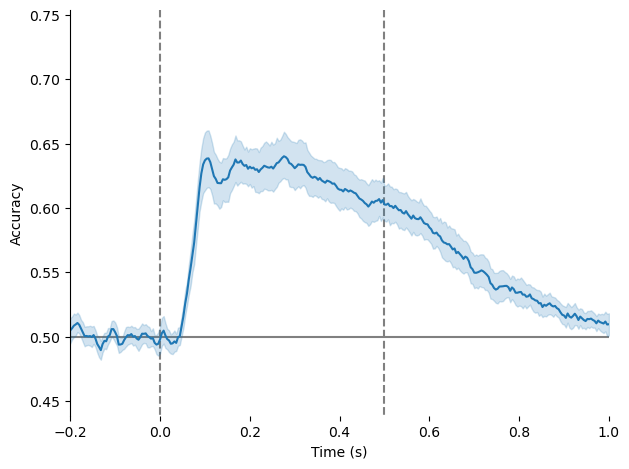

In [5]:
pairwise_decoding, subjs = load_files(glob(f'{input_path}/PairwiseDecoding/*reg-gaze-{regress_gaze}.csv.gz'))
print(subjs)
decoding_avg = pairwise_decoding.groupby(['time', 'subj']).mean(numeric_only=True).reset_index()
_, ax = plt.subplots()
ymin, ymax = decoding_avg['distance'].min(), decoding_avg['distance'].max()
sns.lineplot(x='time', y='distance', data=decoding_avg, ax=ax)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Time (s)')     
ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
        colors='gray', linestyles='dashed', zorder=0)
ax.hlines(y=0.5, xmin=decoding_avg.time.min(), xmax=decoding_avg.time.max(),
        colors='gray', linestyles='solid', zorder=0)
ax.set_xlim([decoding_avg.time.min(), decoding_avg.time.max()])
ax.set_ylim([ymin, ymax])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
# plt.savefig(f'{figure_path}/pairwise-decoding_nvideos-250_reg-gaze-{regress_gaze}.png')

## Feature - EEG Decoding

In [14]:
def mean_of_arrays(series):
    # Stack arrays vertically and compute mean along the first axis (rows)
    return np.nanmean(np.vstack(series),axis=0)

# Define a function to calculate the 2.5% and 97.5% percentiles of an array
def compute_confidence_intervals(arr):
    lower = np.nanpercentile(arr, 2.5)
    upper = np.nanpercentile(arr, 97.5)
    return lower, upper

def cluster_correction_df(group, column_name):
    feature_name = group[column_name].iloc[0]
    rs = group['r2'].to_numpy()
    ps = group['p'].to_numpy()
    r_nulls = np.vstack(group['r2_null'].to_numpy())
    corrected_ps = cluster_correction(rs, ps, r_nulls, desc=f'{feature_name} progress')
    return  pd.Series(corrected_ps, index=group['time'])

def calculate_p_df(row):
    r_value = row['r2']  # The 'r' value for the current row
    r_null_array = row['r2_null']  # The 'r_null' array for the current row
    return calculate_p(r_null_array, r_value, n_perm_=len(r_null_array), H0_='greater')

In [7]:
def feature_colors():
    d = dict()
    d['filler'] = 'white'
    d['AlexNet-conv2'] = 'gray'
    d['motion energy'] = 'gray'
    d['face centrality'] = 'gray'
    d['face area'] = 'gray'
    d['indoor'] = 'mustard'
    d['expanse'] = 'mustard'
    d['object'] = 'mustard'
    d['agent distance'] = 'purple'
    d['facingness'] = 'purple'
    d['joint action'] = 'cyan'
    d['communication'] = 'cyan'
    d['valence'] = 'reddish'
    d['arousal'] = 'reddish'
    return d

def custom_palette(rgb=True):
    colors = dict()
    if rgb:
        colors['white'] = tuple(np.array([256., 256., 256.]) / 256)
        colors['gray'] = tuple(np.array([50., 50., 50.]) / 256)
        colors['bluegray'] = tuple(np.array([50., 62., 128.]) / 256)
        colors['mustard'] = tuple(np.array([245., 221., 64.]) / 256)
        colors['purple'] = tuple(np.array([133., 88., 244.]) / 256)
        colors['cyan'] = tuple(np.array([115., 210., 223.]) / 256)
        colors['reddish'] = tuple(np.array([218., 83., 91.]) / 256)
    else:
        colors['white'] = '#FFFFFF'
        colors['gray'] = '#323232'
        colors['bluegray'] = '#323E7F'
        colors['mustard'] = '#F5DD40'
        colors['purple'] = '#8558F4'
        colors['cyan'] = '#73D2DF'
        colors['reddish'] = '#DA535B'
    return colors

def plot_decoding(results_, features_, out_file=None,
                  cols=3, color_subplots=False, linewidth=2):
    if color_subplots:
        colors = feature_colors()
        palette = custom_palette()

    # Make the subplots and remove empty axes
    rows = int(np.ceil(len(features_)/cols))
    _, axes = plt.subplots(rows, cols,
                           figsize=(cols*2.5, rows*2.5), 
                           sharex=True, sharey=True,
                           constrained_layout=True)
    axes = axes.flatten()
    if len(axes) > len(features_):
        trim_axs(axes, len(features_)-len(axes))

    # Find the same y across features
    ymin, ymax = results_['lower_ci'].min(), results_['upper_ci'].max()

    for ax, (feature, time_corr) in zip(axes, results_.groupby('feature')):
        if color_subplots is True:
            color = palette[colors[feature]]
        else:
            color = 'blue'
        sns.lineplot(x='Time (s)', y='Prediction ($r$)',
                      data=time_corr, ax=ax, color=color,
                      linewidth=linewidth)
        ax.fill_between(x=time_corr['Time (s)'],
                        y1=time_corr['lower_ci'],
                        y2=time_corr['upper_ci'],
                        color='gray', alpha=0.2)
        
        # Mark the start and stop of the video and 0 encoding performance
        ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
                colors='gray', linestyles='dashed', zorder=0)
        ax.hlines(y=0, xmin=time_corr['Time (s)'].min(),
                  xmax=time_corr['Time (s)'].max(),
                  colors='gray', linestyles='solid', zorder=0)
        
        # Plot significance lines 
        label, n = ndimage.label(time_corr['p_corrected'] < 0.05)
        if n > 0:
            for i in range(n):
                cluster_time = time_corr.loc[label == i+1, 'Time (s)']
                ax.hlines(xmin=cluster_time.min(),
                           xmax=cluster_time.max(), y=-0.05,
                           colors=color, linewidth=linewidth)
        
        # Set x and y limits 
        ax.set_xlim([time_corr['Time (s)'].min(),
                    time_corr['Time (s)'].max()])
        ax.set_ylim([ymin, ymax])

        # Remove boxes
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        onset = time_corr.loc[time_corr.p_corrected < 0.05, 'Time (s)'].min()
        if not np.isnan(onset):
            ax.set_title(f'{feature} ({int(onset*1000)} ms)', size=12)
        else:
            ax.set_title(feature, size=12)
    plt.tight_layout()
    if out_file is not None:
        plt.savefig(out_file)
        plt.close()

In [8]:
group_feature_file = f'{out_path}/feature_decoding.csv'
if not os.path.exists(f'{out_path}/feature_decoding.csv') or overwrite: 
    files = glob(f'{input_path}/FeatureDecoding/*reg-gaze-{regress_gaze}_channel-selection-False_decoding.pkl')
    df, subjs = load_files(files)
    df['feature'] = df.feature.astype('str')
    print(f'{subjs=}')

    # Average across subjects
    result = df.groupby(['time', 'feature']).agg({
        'r': 'mean',  # For scalar values, use the built-in 'mean' function
        'r_null': mean_of_arrays,  # For numpy arrays, use the custom function
        'r_var': mean_of_arrays
    }).reset_index()

    # Compute the confidence intervals across subjec ts
    result[['lower_ci', 'upper_ci']] = result['r_var'].apply(lambda arr: pd.Series(compute_confidence_intervals(arr)))

    # Calculate the p values across subjects
    result['p'] = result.apply(calculate_p_df, axis=1)

    # drop alexnet and moten
    result = result.loc[~result.feature.str.contains('alexnet')]
    result = result.loc[~result.feature.str.contains('moten')]
    result.reset_index(drop=True, inplace=True)

    # Perform cluster correction on the p values
    result = result.sort_values(by=['feature', 'time']).reset_index(drop=True)
    corrected_p_series = result.groupby('feature').apply(cluster_correction_df, column_name='feature')
    corrected_p_series = corrected_p_series.apply(pd.Series).stack().reset_index(name='p_corrected')
    result = result.merge(corrected_p_series, on=['feature', 'time']) # Combine wiht original data frame

    # Make a column for plotting the significant clusters
    result['sig_plotting'] = np.nan
    result.loc[result.p_corrected < 0.05, 'sig_plotting'] = -0.05

    # Rename columns for pretty plotting 
    result.rename(columns={'r': 'Prediction ($r$)',
                           'time': 'Time (s)'}, inplace=True)

    # Drop the array columns which have been used to compute p values and CIs 
    result.drop(columns=['r_null', 'r_var'], inplace=True)

    # Save the output to disk
    result.to_csv(group_feature_file, index=False)
else:
    result = pd.read_csv(group_feature_file)

In [9]:
annotated_results = result[~result['feature'].str.contains('alexnet', na=False)]
annotated_results = annotated_results[~annotated_results['feature'].str.contains('moten', na=False)]
annotated_results = annotated_results[~annotated_results['feature'].str.contains('facingness', na=False)]
annotated_results = annotated_results[~annotated_results['feature'].str.contains('joint_action', na=False)]
annotated_results = annotated_results[~annotated_results['feature'].str.contains('valence', na=False)]
rename_map = {f: f.replace('_', ' ') for f in annotated_features if f not in ['facingness', 'joint_action', 'valence']}
rename_map['object_directedness'] = 'object'
annotated_results['feature'] = annotated_results['feature'].replace(rename_map)
cat_type = pd.CategoricalDtype(categories=list(rename_map.values()), ordered=True)
annotated_results['feature'] = annotated_results['feature'].astype(cat_type)
plot_decoding(annotated_results, list(rename_map.values()),
              out_file=f'{figure_path}/features.pdf',
             color_subplots=True, linewidth=3)

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_49824/2559538720.py:102: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


In [ ]:
# moten_results = result[result['feature'].str.contains('moten', na=False)]
# moten_features = [feature for feature in result.feature.unique() if 'moten' in feature]
# cat_type = pd.CategoricalDtype(categories=moten_features, ordered=True)
# moten_results['feature'] = moten_results['feature'].astype(cat_type)
# plot_decoding(moten_results, moten_features)

In [ ]:
# alexnet_results = result[result['feature'].str.contains('alexnet', na=False)]
# alexnet_features = [feature for feature in result.feature.unique() if 'alexnet' in feature]
# cat_type = pd.CategoricalDtype(categories=alexnet_features, ordered=True)
# alexnet_results['feature'] = alexnet_results['feature'].astype(cat_type)
# plot_decoding(alexnet_results, alexnet_features)

## fMRI-EEG Decoding

In [10]:
def plot_fmri_decoding(results_, rois_, out_file=None,
                       cols=3, linewidth=2,
                       xmin=-.2, xmax=1.3, ymin=-.07):

    # Make the subplots and remove empty axes
    rows = int(np.ceil(len(rois_)/cols))
    _, axes = plt.subplots(rows, cols,
                           figsize=(cols*2.5, rows*2.5), 
                           sharex=True, sharey=True,
                           constrained_layout=True)
    axes = axes.flatten()
    if len(axes) > len(rois_):
        trim_axs(axes, len(rois_)-len(axes))

    # Find the same y across features
    ymax = results_['upper_ci'].max()

    for ax, (roi, time_corr) in zip(axes, results_.groupby('roi')):
        sns.lineplot(x='Time (s)', y='Prediction ($r$)',
                      data=time_corr, ax=ax, color='gray',
                      linewidth=linewidth)
        ax.fill_between(x=time_corr['Time (s)'],
                        y1=time_corr['lower_ci'],
                        y2=time_corr['upper_ci'],
                        color='gray', alpha=0.3)
        
        # Mark the start and stop of the video and 0 encoding performance
        ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
                colors='gray', linestyles='dashed', zorder=0)
        ax.hlines(y=0, xmin=xmin, xmax=xmax,
                  colors='gray', linestyles='solid', zorder=0)
        
        # Plot significance lines 
        label, n = ndimage.label(time_corr['p_corrected'] < 0.05)
        if n > 0:
            for i in range(n):
                cluster_time = time_corr.loc[label == i+1, 'Time (s)']
                ax.hlines(xmin=cluster_time.min(),
                           xmax=cluster_time.max(), y=-0.05,
                           colors='gray', linewidth=linewidth)
        
        # Set x and y limits 
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])

        # Remove boxes
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        onset = time_corr.loc[time_corr.p_corrected < 0.05, 'Time (s)'].min()
        if not np.isnan(onset):
            ax.set_title(f'{roi} ({int(onset*1000)} ms)', size=12)
        else:
            ax.set_title(roi, size=12)
    plt.tight_layout()
    if out_file is not None:
        plt.savefig(out_file)
        plt.close()

In [29]:
group_fmri_file = f'{out_path}/fmri_roi_decoding.csv'
if (not os.path.exists(group_fmri_file)) or (overwrite):
    df, subjs = load_files(glob(f'{input_path}/fMRIDecoding/sub-*_reg-gaze-{regress_gaze}_roi-decoding.pkl.gz'),
                            cat='roi', cat_order=rois)
    print(sorted(subjs))
    # Average across subjects
    result = df.groupby(['category', 'time', 'roi']).agg({
        'r2': 'mean',  # For scalar values, use the built-in 'mean' function
        'r2_null': mean_of_arrays,  # For numpy arrays, use the custom function
        'r2_var': mean_of_arrays
    }).reset_index()

    # Compute the confidence intervals across subjec ts
    result[['lower_ci', 'upper_ci']] = result['r2_var'].apply(lambda arr: pd.Series(compute_confidence_intervals(arr)))

    # Calculate the p values across subjects
    result['p'] = result.apply(calculate_p_df, axis=1)

    # Perform cluster correction on the p values
    for category, r_category in tqdm(result.groupby('category'), desc='Category correction', leave=True): 
        r_category = r_category.sort_values(by=['roi', 'time']).reset_index(drop=True)
        corrected_p_series = r_category.groupby('roi').apply(cluster_correction_df, column_name='roi')
        corrected_p_series = corrected_p_series.apply(pd.Series).stack().reset_index(name='p_corrected')
        corrected_p_series['category'] = category
        result = result.merge(corrected_p_series, on=['category', 'roi', 'time']) # Combine with original data frame

    # Make a column for plotting the significant clusters
    result['sig_plotting'] = np.nan
    result.loc[result.p_corrected < 0.05, 'sig_plotting'] = -0.05

    # Rename columns for pretty plotting 
    result.rename(columns={'r2': 'Explained Variance ($r^2$)',
                        'time': 'Time (s)'}, inplace=True)

    # Drop the array columns which have been used to compute p values and CIs 
    result.drop(columns=['r2_null', 'r2_var'], inplace=True)

    # Save the output to disk
    result.to_csv(group_fmri_file, index=False)
else:
    result = pd.read_csv(group_fmri_file)

xmin, xmax = result['Time (s)'].min(), result['Time (s)'].max()
stream_results = result[~result['roi'].str.contains('face', na=False)]
stream_results = stream_results[~stream_results['roi'].str.contains('FFA', na=False)]
stream_results = stream_results[~stream_results['roi'].str.contains('PPA', na=False)]
rois = ['EVC', 'MT', 'EBA', 'LOC',
        'pSTS', 'aSTS']
stream_results['roi'] = pd.Categorical(stream_results['roi'], categories=rois, ordered=True)
plot_fmri_decoding(stream_results, rois,
                   out_file=f'{figure_path}/rois.pdf',
                   linewidth=3, xmin=xmin, xmax=xmax)

KeyboardInterrupt: 

## fMRI Whole Brain

In [23]:
import nibabel as nib
import numpy as np
from nilearn import plotting, surface
import nibabel as nib
from src.tools import camera_switcher
import cv2
import os
import re
import warnings

os.environ["SUBJECTS_DIR"] = "/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_analysis/data/raw/freesurfer"
os.environ["FREESURFER_HOME"] = "/Applications/freesurfer"


def compute_surf_stats(prefix, sub, hemi):
    file = f'{prefix}_hemi-{hemi}.mgz'
    if not os.path.exists(file):
        cmd = '/Applications/freesurfer/bin/mri_vol2surf '
        cmd += f'--src {prefix}.nii.gz '
        cmd += f'--out {file} '
        cmd += f'--regheader sub-{sub} '
        cmd += f'--hemi {hemi} '
        cmd += '--projfrac 1 '
        cmd += '> /dev/null 2>&1'
        os.system(cmd)
    return surface.load_surf_data(file)


def load_surf_mesh(path, sub, hemi):
    return f'{path}/freesurfer/sub-{sub}/surf/{hemi}.inflated', \
            f'{path}/freesurfer/sub-{sub}/surf/{hemi}.sulc'


def plot_stats(surf_mesh, bg_map, surf_map, hemi_, figure_prefix,
               cmap=sns.color_palette('icefire', as_cmap=True),
               vmax=0.4, threshold = 1e-3,
               views=['lateral', 'medial', 'ventral'], title=None):
    if hemi_ == 'lh':
        hemi_name = 'left'
    else:
        hemi_name = 'right'


    for view in views:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True")
            warnings.filterwarnings("ignore", message="vmin cannot be chosen when cmap is symmetric")
            fig = plotting.plot_surf_stat_map(surf_mesh=surf_mesh,
                                                stat_map=surf_map,
                                                bg_map=bg_map,
                                                symmetric=True,
                                                vmax=vmax,
                                                threshold=threshold,
                                                engine='plotly',
                                                colorbar=True,
                                                view=view,
                                                cmap=cmap,
                                                title=title,
                                                title_font_size=30,
                                                hemi=hemi_name)
            fig.figure.update_layout(scene_camera=camera_switcher(hemi_, view))
            fig.figure.write_image(f'{figure_prefix}_view-{view}_hemi-{hemi_}.png')


def pngs_to_mp4(input_folder, output_file,
                file_pattern, fps=9, frame_size=None,
                start_frame=None, end_frame=None):
    """
    Converts a series of PNG images in a folder into an MP4 video file.

    Parameters:
    - input_folder: Path to the folder containing PNG images.
    - output_file: Path to save the MP4 video file.
    - fps: Frames per second in the output video.
    - frame_size: Tuple of (width, height) for the video frame size. If None, the size of the first image is used.
    """

    # Get all the PNG files in the folder
    images = glob(os.path.join(input_folder, file_pattern))
    images = sorted(images)  # Sort the images by name
    if start_frame is not None and end_frame is not None: 
        images = [image for image in images if start_frame < int(re.search("timepoint-(\d+)", image).group(1)) < end_frame]

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec used to compress the frames
    if not frame_size:
        # If frame size is not specified, use the first image to determine the size
        first_image = cv2.imread(images[0])
        frame_size = (first_image.shape[1], first_image.shape[0])
    out = cv2.VideoWriter(output_file, fourcc, fps, frame_size)

    for image_path in images:
        img = cv2.imread(image_path)
        # Resize the image to match the frame size, if necessary
        if img.shape[1] != frame_size[0] or img.shape[0] != frame_size[1]:
            img = cv2.resize(img, frame_size)
        out.write(img)

    # Release everything when the job is finished
    out.release()
    cv2.destroyAllWindows()

**Combine Whole Brain results across EEG subjects**

**THIS IS VERY SLOW**


In [ ]:
whole_brain_files = glob(f'{out_path}/sub-*_whole-brain-group.csv.gz')
if len(whole_brain_files) != 4: 
    files = sorted(glob(f'{input_path}/fMRIDecoding/sub-*_reg-gaze-False_time-*_whole-brain-decoding.csv.gz'))
    df = []
    for file in tqdm(files, total=len(files), desc='Loading whole brain results'):
        df.append(pd.read_csv(file))
    df = pd.concat(df)

    df = df.groupby(['subj_id', 'time', 'voxel_id']).mean(numeric_only=True).reset_index()
    for id, time_df in tqdm(df.groupby('subj_id'), total=len(df.subj_id.unique()), desc='Saving fMRI subj'):
        time_df.to_csv(f'{out_path}/sub-{str(id).zfill(2)}_whole-brain-group.csv.gz', index=False)


In [20]:
plotting_subj = 2
start, end = -.1, .75
raw_path = f'{top_path}/data/raw'
subj_id = str(plotting_subj).zfill(2)
Path(f'{input_path}/{process}/brain_plots').mkdir(parents=True, exist_ok=True)
Path(f'{figure_path}/brain_plots').mkdir(parents=True, exist_ok=True)

time_df = pd.read_csv(f'{out_path}/sub-{str(plotting_subj).zfill(2)}_whole-brain-group.csv.gz')
time_df[['i_index', 'j_index', 'k_index']] = time_df[['i_index', 'j_index', 'k_index']].astype('int')
time_df = time_df.loc[(time_df.time > start) & (time_df.time < end)].reset_index(drop=True)

In [21]:
run = True
if run:
    i = -1
    title = None
    time_iterator = tqdm(time_df.groupby('time'), total=len(time_df.time.unique()), desc='Plotting subjects')
    for time, cur_df in time_iterator:
        i += 1 
        if (title is None) or ((time*1000) % 10 == 0): 
            title = f'{time * 1000:.0f} ms' 
        time_point = str(i).zfill(3)
        stat_file = f'{input_path}/{process}/brain_plots/sub-{subj_id}_timepoint-{time_point}'
        plot_file = f'{figure_path}/brain_plots/sub-{subj_id}_timepoint-{time_point}'

        img = nib.load(f'{raw_path}/fmri_betas/sub-{subj_id}_space-T1w_desc-train-fracridge_data.nii.gz')

        dims = img.shape[:-1]
        header, affine = img.header, img.affine

        scores_arr = cur_df['r'].to_numpy()
        indices = cur_df[['i_index', 'j_index', 'k_index']].to_numpy()

        score_img = np.zeros(dims)
        score_img[indices[:, 0], indices[:, 1], indices[:, 2]] = scores_arr
        score_img = nib.Nifti1Image(score_img, affine=affine, header=header)
        nib.save(score_img, f'{stat_file}.nii.gz')

        for hemi in ['lh', 'rh']:
            surf = compute_surf_stats(stat_file, subj_id, hemi)
            inflated, sulcus = load_surf_mesh(raw_path, subj_id, hemi)
            plot_stats(inflated, sulcus, surf, hemi, plot_file, title=title)

Plotting subjects: 100%|██████████| 106/106 [52:36<00:00, 29.78s/it]


In [24]:
for hemi in ['lh', 'rh']: 
        for view in ['lateral', 'medial', 'ventral']:
                pngs_to_mp4(input_folder=f'{figure_path}/brain_plots',
                        output_file=f'{figure_path}/sub-{str(plotting_subj).zfill(2)}_view-{view}_hemi-{hemi}.mp4',
                        file_pattern=f'sub-{str(plotting_subj).zfill(2)}*view-{view}*hemi-{hemi}*.png')

## Gaze decoding

In [ ]:
# def plot_feature_gaze_decoding(results, out_file=None):
#     _, ax = plt.subplots()
#     sns.barplot(x='feature', y='r', data=results, errorbar=None, ax=ax, color='gray')
#     sns.swarmplot(x='feature', y='r', hue='subj', data=results, ax=ax, palette='husl')
#     ax.hlines(y=0, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
#         colors='black', linestyles='solid', zorder=1)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.set_xticklabels(features, rotation=45, ha='right')
#     ax.set_xlabel('')
#     ax.set_ylabel('Prediction (r)')
#     ax.legend(bbox_to_anchor=(.95, .95))
#     plt.tight_layout()
#     if out_file is not None:
#         plt.savefig(out_file)
#         plt.close()

In [ ]:
# results, _ = load_files(glob(f'{input_path}/GazeDecoding/*decoding.csv'),
#                     cat='feature', cat_order=features,
#                     subj_include=extra_test)
# results['subj'] = results['subj'].astype(pd.CategoricalDtype(categories=extra_test, ordered=True))
# # out_file = f'{figure_path}/feature_gaze_rsa.png'
# plot_feature_gaze_decoding(results)